In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
import sounddevice as sd
import wavio
from tensorflow.keras.layers import LSTM


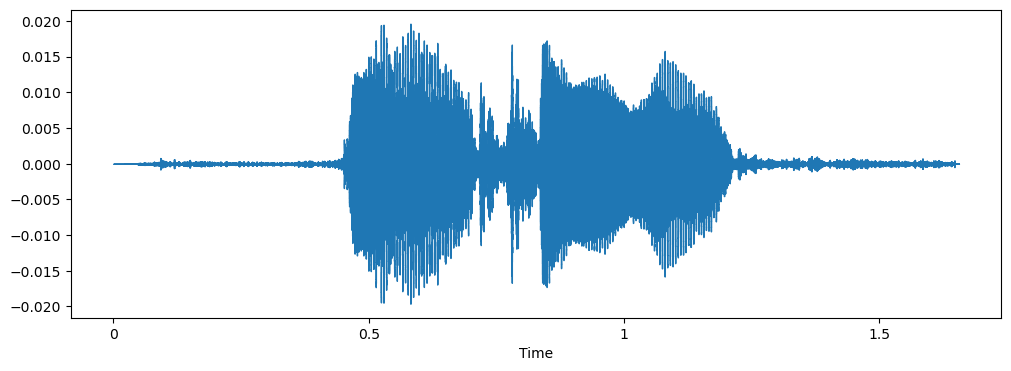

In [2]:


data, sample_rate=librosa.load("DataSet/laafi/65a5a9901647a_170535566465a5a9901a66c.wav")

plt.figure(figsize=(12,4))

librosa.display.waveshow(data, sr=sample_rate)

In [3]:
def extract_features(file_path, n_mfcc=42, max_pad_len=100):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    pad_width = max_pad_len - mfccs.shape[1]
    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]
    return mfccs.T  # Transpose to shape (num_frames, num_mfcc)
# Define your folder structure
data_path = 'DataSet/'
classes = ['laafi', 'nii-yibeugo','nii-zabre', 'ni-winiga', 'oub ya laafi','winig-kibare','yibeog-kibare', 'yika laafi', 'zabre kibare', 'zackramba']
dic={}
extracted_features = []
labels = []
c = 0
for i, class_name in enumerate(classes):
    class_path = os.path.join(data_path, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        try:
            features = extract_features(file_path)
            extracted_features.append(features)
            labels.append(i)
            c += 1
        except Exception as e:
            print(f"Removing unsupported file: {file_path}")
            os.remove(file_path)
    print(i,class_name,c)
    dic[class_name]=c
    c = 0


0 laafi 291
1 nii-yibeugo 248
2 nii-zabre 282
3 ni-winiga 285
4 oub ya laafi 256
5 winig-kibare 260
6 yibeog-kibare 278
7 yika laafi 255
8 zabre kibare 248
9 zackramba 262


In [3]:
print(dic)

{'laafi': 291, 'nii-yibeugo': 248, 'nii-zabre': 282, 'ni-winiga': 285, 'oub ya laafi': 256, 'winig-kibare': 260, 'yibeog-kibare': 278, 'yika laafi': 255, 'zabre kibare': 248, 'zackramba': 262}


In [4]:

# Convert to numpy arrays
X = np.array(extracted_features)
y = np.array(labels)

# Shuffle and split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))


In [5]:
len(extracted_features)

2665

In [ ]:

from tensorflow.keras.layers import BatchNormalization
# Define the model
input_shape = X_train.shape[1:]  # This should be (num_frames, num_mfcc)
input_layer = Input(shape=input_shape)
x = LSTM(100, return_sequences=True)(input_layer) #512, 256, 128, 100
x = BatchNormalization()(x)
x = Dropout(0.5)(x) #entre 0.1 et 0.5, aide beaucoup
x = LSTM(100)(x) #128
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(200, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(classes), activation='softmax')(x)# taille des neurones de sorties
model = Model(input_layer, output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#f1 score, 
# Print the model summary
model.summary()


### test sur les batch_sizes

In [15]:

batch_sizes = [16, 32, 64, 128]

for batch_size in batch_sizes:
    print(f'Training with batch size: {batch_size}')
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=batch_size)
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Validation Loss: {loss}')
    print(f'Validation Accuracy: {accuracy}')
    
    # Define the model
    input_shape = X_train.shape[1:]  # This should be (num_frames, num_mfcc)
    input_layer = Input(shape=input_shape)
    x = LSTM(100, return_sequences=True)(input_layer) #512, 256, 128, 100
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x) #entre 0.1 et 0.5, aide beaucoup
    x = LSTM(100)(x) #128
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(200, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(len(classes), activation='softmax')(x)# taille des neurones de sorties
    model = Model(input_layer, output_layer)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

Training with batch size: 16
Epoch 1/20
134/134 [==============================] - 48s 283ms/step - loss: 3.3018 - accuracy: 0.1083 - val_loss: 2.3152 - val_accuracy: 0.1201
Epoch 2/20
134/134 [==============================] - 35s 259ms/step - loss: 3.0246 - accuracy: 0.1116 - val_loss: 2.3480 - val_accuracy: 0.1351
Epoch 3/20
134/134 [==============================] - 36s 270ms/step - loss: 2.7837 - accuracy: 0.1093 - val_loss: 2.3316 - val_accuracy: 0.1182
Epoch 4/20
134/134 [==============================] - 36s 269ms/step - loss: 2.6417 - accuracy: 0.1220 - val_loss: 2.3327 - val_accuracy: 0.1144
Epoch 5/20
134/134 [==============================] - 33s 248ms/step - loss: 2.5511 - accuracy: 0.1262 - val_loss: 2.3632 - val_accuracy: 0.1238
Epoch 6/20
134/134 [==============================] - 36s 265ms/step - loss: 2.4614 - accuracy: 0.1318 - val_loss: 2.2796 - val_accuracy: 0.1538
Epoch 7/20
134/134 [==============================] - 33s 247ms/step - loss: 2.3967 - accuracy: 0.135

### Conclusion :bacth size 32 win

In [ ]:

# Evaluate the model with more layer
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

## test sur les dropouts

In [17]:
dropouts=[0.1, 0.2, 0.3, 0.4,0.5]
for dropout in dropouts:
    # Define the model
    input_shape = X_train.shape[1:]  # This should be (num_frames, num_mfcc)
    input_layer = Input(shape=input_shape)
    x = LSTM(100, return_sequences=True)(input_layer) #512, 256, 128, 100
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x) #entre 0.1 et 0.5, aide beaucoup
    x = LSTM(100)(x) #128
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    x = Dense(200, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    output_layer = Dense(len(classes), activation='softmax')(x)# taille des neurones de sorties
    model = Model(input_layer, output_layer)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    #f1 score, 
    # Print the model summary
    model.summary()
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    ## modifier le batch size >32
    
    # Evaluate the model with more layer
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'dropout : {dropout} Test accuracy: {test_acc}')

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 100, 42)]         0         
                                                                 
 lstm_19 (LSTM)              (None, 100, 100)          57200     
                                                                 
 batch_normalization_24 (Bat  (None, 100, 100)         400       
 chNormalization)                                                
                                                                 
 dropout_27 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_20 (LSTM)              (None, 100)               80400     
                                                                 
 batch_normalization_25 (Bat  (None, 100)              400       
 chNormalization)                                          

### conclusion dropout 0.1 best

### test des nombre de neurones dans les couches

In [20]:
def create_model(lstm_num,dense_num):
    # Define the model
    input_shape = X_train.shape[1:]  # This should be (num_frames, num_mfcc)
    input_layer = Input(shape=input_shape)
    x = LSTM(lstm_num, return_sequences=True)(input_layer) #512, 256, 128, 100
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x) #entre 0.1 et 0.5, aide beaucoup
    x = LSTM(lstm_num)(x) #128
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(dense_num, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(len(classes), activation='softmax')(x)# taille des neurones de sorties
    model = Model(input_layer, output_layer)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

lstm_units_list = [50, 100, 150]
dense_units_list = [100, 200, 300]

# Dictionnaire pour enregistrer les résultats
results = {}
for lstm_units in lstm_units_list:
    for dense_units in dense_units_list:
        print(f'Testing model with LSTM units: {lstm_units} and Dense units: {dense_units}')
        model = create_model(lstm_units, dense_units)
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=0)
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')
        results[(lstm_units, dense_units)] = accuracy


Testing model with LSTM units: 50 and Dense units: 100
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 100, 42)]         0         
                                                                 
 lstm_29 (LSTM)              (None, 100, 50)           18600     
                                                                 
 batch_normalization_39 (Bat  (None, 100, 50)          200       
 chNormalization)                                                
                                                                 
 dropout_42 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_30 (LSTM)              (None, 50)                20200     
                                                                 
 batch_normalization_40 (Bat  (None, 50)               200       
 ch

In [21]:

# Afficher les résultats
for config, accuracy in results.items():
    print(f'LSTM units: {config[0]}, Dense units: {config[1]} -> Validation Accuracy: {accuracy}')

LSTM units: 50, Dense units: 100 -> Validation Accuracy: 0.18198874592781067
LSTM units: 50, Dense units: 200 -> Validation Accuracy: 0.19136960804462433
LSTM units: 50, Dense units: 300 -> Validation Accuracy: 0.17636021971702576
LSTM units: 100, Dense units: 100 -> Validation Accuracy: 0.24953095614910126
LSTM units: 100, Dense units: 200 -> Validation Accuracy: 0.3133208155632019
LSTM units: 100, Dense units: 300 -> Validation Accuracy: 0.21763601899147034
LSTM units: 150, Dense units: 100 -> Validation Accuracy: 0.32457786798477173
LSTM units: 150, Dense units: 200 -> Validation Accuracy: 0.24202626943588257
LSTM units: 150, Dense units: 300 -> Validation Accuracy: 0.3058161437511444


#### Conclusion
LSTM units: 150, Dense units: 100 -> Validation Accuracy: 0.32457786798477173
LSTM units: 100, Dense units: 200 -> Validation Accuracy: 0.3133208155632019
LSTM units: 150, Dense units: 300 -> Validation Accuracy: 0.3058161437511444
voila les 2 meilleurs resulats

#### augmentons l'epoche pour voir le resultat

In [12]:
def create_model(lstm_num,dense_num):
    # Define the model
    input_shape = X_train.shape[1:]  # This should be (num_frames, num_mfcc)
    input_layer = Input(shape=input_shape)
    x = LSTM(lstm_num, return_sequences=True)(input_layer) #512, 256, 128, 100 
    x = Dropout(0.1)(x) #entre 0.1 et 0.5, aide beaucoup
    x = LSTM(lstm_num)(x) # 
    x = Dropout(0.1)(x)
    x = Dense(dense_num, activation='relu')(x) 
    x = Dropout(0.1)(x)
    output_layer = Dense(len(classes), activation='softmax')(x)# taille des neurones de sorties
    model = Model(input_layer, output_layer)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
 
print(f'Testing model with LSTM units: {100} and Dense units: {200}')
model = create_model(100, 200)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=70, batch_size=32, verbose=1)
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}') 


Testing model with LSTM units: 100 and Dense units: 200
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 42)]         0         
                                                                 
 lstm_10 (LSTM)              (None, 100, 100)          57200     
                                                                 
 dropout_15 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_16 (Dropout)        (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 200)               20200     
                                                                 
 dr

In [13]:
def create_model(lstm_num,dense_num):
    # Define the model
    input_shape = X_train.shape[1:]  # This should be (num_frames, num_mfcc)
    input_layer = Input(shape=input_shape)
    x = LSTM(lstm_num, return_sequences=True)(input_layer) #512, 256, 128, 100 
    x = Dropout(0.1)(x) #entre 0.1 et 0.5, aide beaucoup
    x = LSTM(lstm_num)(x) # 
    x = Dropout(0.1)(x)
    x = Dense(dense_num, activation='relu')(x) 
    x = Dropout(0.1)(x)
    output_layer = Dense(len(classes), activation='softmax')(x)# taille des neurones de sorties
    model = Model(input_layer, output_layer)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
 
print(f'Testing model with LSTM units: {150} and Dense units: {100}')
model = create_model(150, 100)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=70, batch_size=32, verbose=1)
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')
results[(150, 100)] = accuracy


Testing model with LSTM units: 150 and Dense units: 100
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 42)]         0         
                                                                 
 lstm_12 (LSTM)              (None, 100, 150)          115800    
                                                                 
 dropout_18 (Dropout)        (None, 100, 150)          0         
                                                                 
 lstm_13 (LSTM)              (None, 150)               180600    
                                                                 
 dropout_19 (Dropout)        (None, 150)               0         
                                                                 
 dense_12 (Dense)            (None, 100)               15100     
                                                                 
 dr

NameError: name 'results' is not defined

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f' Test accuracy: {test_acc}')

17/17 [==============================] - 5s 313ms/step - loss: 1.0633 - accuracy: 0.7636
 Test accuracy: 0.7636022567749023


plus on augmente le nombre de neurones LSTM plus cela prend du tempd

In [21]:
def create_model(lstm_num,dense_num):
    # Define the model
    input_shape = X_train.shape[1:]  # This should be (num_frames, num_mfcc)
    input_layer = Input(shape=input_shape)
    x = LSTM(lstm_num, return_sequences=True)(input_layer) #512, 256, 128, 100 
    x = Dropout(0.1)(x) #entre 0.1 et 0.5, aide beaucoup
    x = LSTM(lstm_num)(x) # 
    x = Dropout(0.1)(x)
    x = Dense(dense_num, activation='relu')(x) 
    x = Dropout(0.1)(x)
    output_layer = Dense(len(classes), activation='softmax')(x)# taille des neurones de sorties
    model = Model(input_layer, output_layer)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
     
    return model
 
print(f'Testing model with LSTM units: {150} and Dense units: {300}')
model = create_model(150, 300)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=70, batch_size=32, verbose=1)
loss, accuracy = model.evaluate(X_test, y_test, verbose=0) 
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f' Test accuracy: {test_acc}')



Testing model with LSTM units: 150 and Dense units: 300
Epoch 1/70
67/67 [==============================] - 130s 2s/step - loss: 2.3088 - accuracy: 0.1243 - val_loss: 2.3029 - val_accuracy: 0.1520
Epoch 2/70
67/67 [==============================] - 137s 2s/step - loss: 2.2221 - accuracy: 0.1684 - val_loss: 2.1401 - val_accuracy: 0.1839
Epoch 3/70
67/67 [==============================] - 116s 2s/step - loss: 2.0476 - accuracy: 0.2233 - val_loss: 2.0453 - val_accuracy: 0.2064
Epoch 4/70
67/67 [==============================] - 130s 2s/step - loss: 1.8862 - accuracy: 0.2706 - val_loss: 1.8477 - val_accuracy: 0.2439
Epoch 5/70
67/67 [==============================] - 121s 2s/step - loss: 1.7366 - accuracy: 0.3222 - val_loss: 1.8393 - val_accuracy: 0.3227
Epoch 6/70
67/67 [==============================] - 122s 2s/step - loss: 1.6537 - accuracy: 0.3696 - val_loss: 1.7062 - val_accuracy: 0.3546
Epoch 7/70
67/67 [==============================] - 125s 2s/step - loss: 1.5411 - accuracy: 0.4104

In [22]:
def create_model(lstm_num,dense_num):
    # Define the model
    input_shape = X_train.shape[1:]  # This should be (num_frames, num_mfcc)
    input_layer = Input(shape=input_shape)
    x = LSTM(lstm_num, return_sequences=True)(input_layer) #512, 256, 128, 100 
    x = Dropout(0.1)(x) #entre 0.1 et 0.5, aide beaucoup
    x = LSTM(lstm_num)(x) # 
    x = Dropout(0.1)(x)
    x = Dense(dense_num, activation='relu')(x) 
    x = Dropout(0.1)(x)
    output_layer = Dense(len(classes), activation='softmax')(x)# taille des neurones de sorties
    model = Model(input_layer, output_layer)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
 
print(f'Testing model with LSTM units: {64} and Dense units: {128}')
model = create_model(64, 128)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=70, batch_size=32, verbose=1)
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}') 
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f' Test accuracy: {test_acc}')

Testing model with LSTM units: 64 and Dense units: 128
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 100, 42)]         0         
                                                                 
 lstm_26 (LSTM)              (None, 100, 64)           27392     
                                                                 
 dropout_39 (Dropout)        (None, 100, 64)           0         
                                                                 
 lstm_27 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_40 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 128)               8320      
                                                                 
 dr

In [ ]:
# Load the saved model
model = load_model('audio_classification_model.h5')

def predict_audio_class(model, file_path, n_mfcc=42, max_pad_len=100):
   # Extract features from the new audio file
   features = extract_features(file_path, n_mfcc, max_pad_len)
   
   # Reshape to match the input shape of the model
   features = np.expand_dims(features, axis=0)  # Add batch dimension
   features = np.expand_dims(features, axis=-1) # Add channel dimension
   
   # Make a prediction
   predictions = model.predict(features)
   
   # Get the predicted class
   predicted_class = np.argmax(predictions, axis=1)
   
   return predicted_class
# Function to record audio
def record_audio(duration=5, sample_rate=22050, file_path='recorded_audio.wav'):
    print("Recording...")
    recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
    sd.wait()  # Wait until recording is finished
    print("Recording finished")
    wavio.write(file_path, recording, sample_rate, sampwidth=2)
    return file_path


# Record and test the model with a new audio file
file_path = record_audio()
predicted_class = predict_audio_class(model, file_path)
print(f'The predicted class is: {classes[predicted_class[0]]}') 


a 30  150 and Dense units: 300 lemporte avc 0.7279549837112427
aallons a 70

A lepoch 70 Testing model with LSTM units: 150 and Dense units: 300 avec un score de 0.801125705242157
Nous garderons alors cette configuration et allons monter juska 130 pour voir le resultat

In [5]:
def create_model(lstm_num,dense_num):
    # Define the model
    input_shape = X_train.shape[1:]  # This should be (num_frames, num_mfcc)
    input_layer = Input(shape=input_shape)
    x = LSTM(lstm_num, return_sequences=True)(input_layer) #512, 256, 128, 100 
    x = Dropout(0.1)(x) #entre 0.1 et 0.5, aide beaucoup
    x = LSTM(lstm_num)(x) # 
    x = Dropout(0.1)(x)
    x = Dense(dense_num, activation='relu')(x) 
    x = Dropout(0.1)(x)
    output_layer = Dense(len(classes), activation='softmax')(x)# taille des neurones de sorties
    model = Model(input_layer, output_layer)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
     
    return model
 
print(f'Testing model with LSTM units: {150} and Dense units: {300}')
model = create_model(150, 300)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1)
loss, accuracy = model.evaluate(X_test, y_test, verbose=0) 
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f' Test accuracy: {test_acc}')



Testing model with LSTM units: 150 and Dense units: 300
Epoch 1/100
67/67 [==============================] - 110s 2s/step - loss: 2.3012 - accuracy: 0.1262 - val_loss: 2.2790 - val_accuracy: 0.1445
Epoch 2/100
67/67 [==============================] - 101s 2s/step - loss: 2.1644 - accuracy: 0.1839 - val_loss: 2.1094 - val_accuracy: 0.2083
Epoch 3/100
67/67 [==============================] - 106s 2s/step - loss: 2.0075 - accuracy: 0.2402 - val_loss: 1.9136 - val_accuracy: 0.2570
Epoch 4/100
67/67 [==============================] - 108s 2s/step - loss: 1.8914 - accuracy: 0.2838 - val_loss: 1.9492 - val_accuracy: 0.2627
Epoch 5/100
67/67 [==============================] - 110s 2s/step - loss: 1.7600 - accuracy: 0.3232 - val_loss: 1.9116 - val_accuracy: 0.2402
Epoch 6/100
67/67 [==============================] - 110s 2s/step - loss: 1.6174 - accuracy: 0.3813 - val_loss: 1.7011 - val_accuracy: 0.3396
Epoch 7/100
67/67 [==============================] - 112s 2s/step - loss: 1.5788 - accuracy:

In [6]:

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)
loss, accuracy = model.evaluate(X_test, y_test, verbose=0) 
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f' Test accuracy: {test_acc}')

Epoch 1/50
67/67 [==============================] - 119s 2s/step - loss: 0.0739 - accuracy: 0.9784 - val_loss: 1.3273 - val_accuracy: 0.7430
Epoch 2/50
67/67 [==============================] - 120s 2s/step - loss: 0.1058 - accuracy: 0.9705 - val_loss: 1.3881 - val_accuracy: 0.7523
Epoch 3/50
67/67 [==============================] - 119s 2s/step - loss: 0.0717 - accuracy: 0.9765 - val_loss: 1.4349 - val_accuracy: 0.7336
Epoch 4/50
67/67 [==============================] - 122s 2s/step - loss: 0.0479 - accuracy: 0.9864 - val_loss: 1.3212 - val_accuracy: 0.7505
Epoch 5/50
67/67 [==============================] - 124s 2s/step - loss: 0.0403 - accuracy: 0.9883 - val_loss: 1.4224 - val_accuracy: 0.7261
Epoch 6/50
67/67 [==============================] - 113s 2s/step - loss: 0.1001 - accuracy: 0.9686 - val_loss: 1.2269 - val_accuracy: 0.7448
Epoch 7/50
67/67 [==============================] - 114s 2s/step - loss: 0.0454 - accuracy: 0.9878 - val_loss: 1.3179 - val_accuracy: 0.7467
Epoch 8/50
67

In [7]:
model.save("audio_model.h5")